# Generating neighborhood classification

Another potential generalizable feature is which neighborhood the stop is present within

In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt 
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt

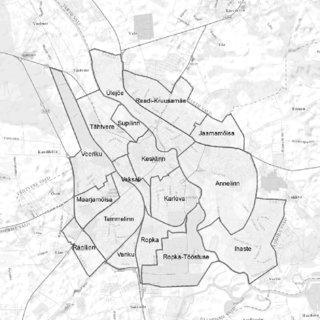

In [2]:
Image(filename='c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Raw_data/Neighbourhoods/Official_neighbourhood.jpg')
# from https://www.researchgate.net/publication/322374300_Network_Connections_and_Neighbourhood_Perception_Using_Social_Media_Postings_to_Capture_Attitudes_among_Twitter_Users_in_Estonia

EPSG:3301


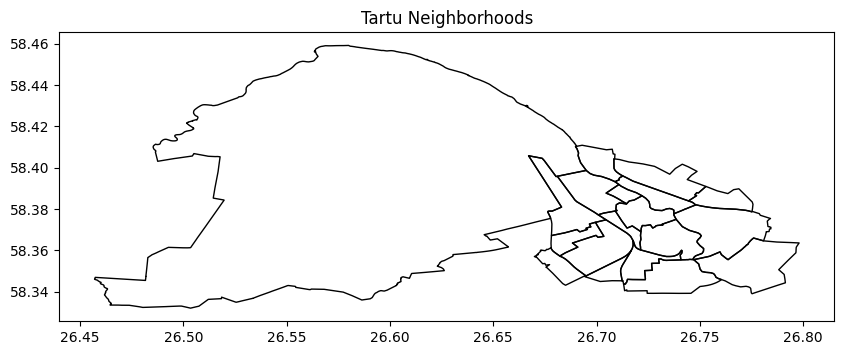

In [3]:
# Loading in the district geojson file

neighborhoods_gdf = gpd.read_file("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Raw_data/Neighbourhoods/Tartu_linnaosad_wgs84.geojson")
neighborhoods_gdf = neighborhoods_gdf.to_crs("EPSG:3301")

neighborhoods_gdf.plot(edgecolor='black', facecolor='none', figsize=(10,10))
print(neighborhoods_gdf.crs)
plt.title("Tartu Neighborhoods")
plt.show()

### Mapping bus stops to individual neghborhoods

In [4]:
def Mapping_districts(df, neighborhoods_gdf):
    """
    Assigns each bus stop to a Tartu neighborhood.
    - Stops inside a polygon get 'within' assignment.
    - Stops outside polygons get assigned to the nearest neighborhood.
    - Returns a GeoDataFrame with the 'NIMI' column for neighborhood.
    """

    # Convert stops to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df, 
        geometry=[Point(xy) for xy in zip(df['stop_lon'], df['stop_lat'])],
        crs="EPSG:3301"  # L-EST 97
    )
    gdf = gdf.to_crs(neighborhoods_gdf.crs)

    
    # First, assign stops that fall within a neighborhood
    Mapping_stops = gpd.sjoin(
        gdf,
        neighborhoods_gdf[['NIMI','geometry']],
        how='left',
        predicate='within'
    )

    # For stops not within any polygon, assign nearest neighborhood
    missing = Mapping_stops['NIMI'].isna()
    if missing.any():
        # Compute nearest polygon for each missing stop
        nearest_idx = gdf.loc[missing].geometry.apply(
            lambda geom: neighborhoods_gdf.geometry.distance(geom).idxmin()
        )
        # Assign neighborhood names
        Mapping_stops.loc[missing, 'NIMI'] = neighborhoods_gdf.loc[nearest_idx, 'NIMI'].values

    # Overlaying and plotting
    fig, ax = plt.subplots(figsize=(6,12))
    neighborhoods_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)
    
    # Plot bus stops
    Mapping_stops.plot(ax=ax, color='red', markersize=20, label='Bus Stops')
    
    # Add labels for neighborhoods (optional)
    for x, y, label in zip(neighborhoods_gdf.geometry.centroid.x, 
                           neighborhoods_gdf.geometry.centroid.y, 
                           neighborhoods_gdf['NIMI']):
        ax.text(x, y, label, fontsize=10, ha='center', va='center')
    
    plt.title("Tartu Neighborhoods and Bus Stops")
    plt.legend()
    plt.show()
    
    return Mapping_stops


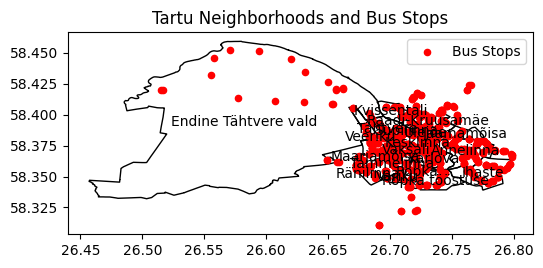

,Stop_ID,Pre_2019,stop_lat,stop_lon,density,geometry,index_right,NIMI
0,7820277-1,True,58.355053,26.679570,5,POINT (26.68 58.355),8.0,Ränilinna
1,7820088-1,True,58.377240,26.727902,12,POINT (26.728 58.377),10.0,Kesklinna
2,7820165-1,True,58.372206,26.780190,1,POINT (26.78 58.372),14.0,Annelinna
3,7820155-1,True,58.369511,26.775310,1,POINT (26.775 58.37),14.0,Annelinna
4,7820014-1,True,58.370453,26.766704,3,POINT (26.767 58.37),14.0,Annelinna


In [5]:
# THIS INLCUES BOTH PRE AND POST 2019 STOPS 
Bus_stop_density = pd.read_csv("C:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/1_Compiling_data/Pipe6/Bus_stop_density.csv")

Mapped_stops = Mapping_districts(Bus_stop_density, neighborhoods_gdf)

Mapped_stops.head()

## Exporting

In [11]:
Keep_cols = ["Stop_ID", "Pre_2019", "density", "NIMI"]
Final = Mapped_stops[Keep_cols]
Final.to_csv("C:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/1_Compiling_data/Pipe7/Mapping_and_density.csv", index = False)

### Seperating Pre and Post 2019 just for vizualisation purposes 

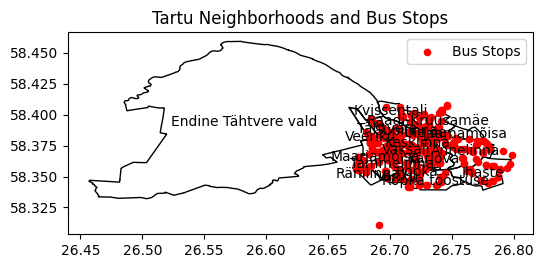

In [12]:

Pre_2019_stops = Bus_stop_density[Bus_stop_density["Pre_2019"] == True]
Pre_2019_MAPPED_stops = Mapping_districts(Pre_2019_stops, neighborhoods_gdf)

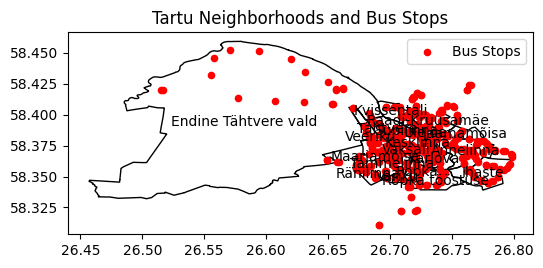

In [13]:
Post_2019_stops = Bus_stop_density[Bus_stop_density["Pre_2019"] == False]
Post_2019_MAPPED_stops = Mapping_districts(Post_2019_stops, neighborhoods_gdf)

## Exporting mapping df and its geographical location - used later down the pipeline

In [14]:
Post_2019 = Post_2019_MAPPED_stops[["Stop_ID", "stop_lat", "stop_lon", "geometry", "NIMI"]]

Post_2019.to_csv("C:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/1_Compiling_data/Pipe7/Post_2019_mapped_stops.csv", index = False)

In [15]:
Post_2019.head()

,Stop_ID,stop_lat,stop_lon,geometry,NIMI
319,NaN,58.352542,26.744627,POINT (26.745 58.353),Ropka tööstuse
320,7820088-1,58.377240,26.727902,POINT (26.728 58.377),Kesklinna
321,7820063-1,58.372088,26.759663,POINT (26.76 58.372),Annelinna
322,7820165-1,58.372206,26.780190,POINT (26.78 58.372),Annelinna
323,7820014-1,58.370453,26.766704,POINT (26.767 58.37),Annelinna
